# Contour Plot of Prediction of Helmholtz Problem

In [26]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys
import os
import torch
import numpy as np

In [28]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.data.helmholtz_dataset import u as u_fn
from src.data.helmholtz_dataset import f as f_fn
from src.nn.pde import helmholtz_operator
from src.utils.plot_prediction import plot_contour

Plot the best and second best models. In case of Helmholtz these are BSpline and Fourier. ... 

In [30]:
BSPLINE_DIST = "../../model/a1/helmholtz_bspline_a1.pth"
FOURIER_DIST = "../../model/a1/helmholtz_fourier_a1.pth"

A1 = 1
A2 = 4
LAMBDA = 1.0

NUM_OF_POINTS = 100
PRINT_EVERY = 1000

MODULE_PATH_LIST = {
    "fourier": FOURIER_DIST,
    "bspline": BSPLINE_DIST,
}

# Dictionary mapping solver names to their corresponding modules
SOLVER_TO_MODULE = {
    "grbf": "src.nn.grbf",
    "jacobi": "src.nn.jacobi",
    "bspline": "src.nn.bspline",
    "chebyshev": "src.nn.chebyshev",
    "param_tanh": "src.nn.tanh_parameterized",
    "tanh": "src.nn.tanh",
    "fourier": "src.nn.fourier",
}

RESULT = "result/helmholtz"

In [31]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "result/helmholtz")
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()
logger.print(f"Result directory {model_dirname}")

##  Generate Testing Data

In [33]:
dom_coords = np.array([[-1.0, -1.0], [1.0, 1.0]], dtype=np.float32)

x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], NUM_OF_POINTS)
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], NUM_OF_POINTS)

x1_mesh, x2_mesh = np.meshgrid(x1, x2)


X_star = torch.concatenate(
    (
        torch.tensor(x1_mesh.flatten()[:, None], dtype=torch.float32),
        torch.tensor(x2_mesh.flatten()[:, None], dtype=torch.float32),
    ),
    1,
).to("cpu")

# Exact solution
u_star = u_fn(X_star, A1, A2)
f_star = f_fn(X_star, A1, A2, LAMBDA)

In [34]:
x1.shape

(100,)

## Load and Test Model

In [35]:
# Load the state from the saved models
model_dict = {
    "fourier": [],
    "bspline": [],
}
for key, model in MODULE_PATH_LIST.items():
    state = torch.load(model)
    config = state.get("config", {})
    solver = config.get("solver")

    # Log model summary and configuration
    logger.print("_summary of the model _")
    logger.print("model path:", model)
    logger.print("model configuration:")
    for k, v in config.items():
        logger.print(f"{k} : {v}")

    # Dynamically import the correct module and class
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        # Initialize fluid and solid models
        model = PINNKAN(config.get("network"), config.get("activation")).to(DEVICE)

    model.load_state_dict(state["model_state_dict"])
    model.eval()

    [u_pred, f_pred] = helmholtz_operator(model, X_star[:, 0:1], X_star[:, 1:2])

    # Relative L2 error
    error_u = torch.norm(u_pred - u_star, 2) / torch.norm(u_star, 2) * 100
    error_f = torch.norm(f_pred - f_star, 2) / torch.norm(f_star, 2) * 100
    logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
    logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

    model_dict[key] = [u_pred, f_pred]
    logger.print("***********************************************************")

INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a1/helmholtz_fourier_a1.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 128
INFO:src.utils.logger:network : [2, 30, 30, 30, 1]
INFO:src.utils.logger:weights : [10.0, 1.0]
INFO:src.utils.logger:solver : fourier
INFO:src.utils.logger:problem : helmholtz
INFO:src.utils.logger:dataset_path : None
INFO:src.utils.logger:total_epochs : 60000
INFO:src.utils.logger:print_every : 10000
INFO:src.utils.logger:save_every : 10000
INFO:src.utils.logger:loss_list : ['lbcs', 'lphy']
INFO:src.utils.logger:log_path : /home/vlq26735/afrah/code/pinn_learnable_activation/checkpoints/Helmholtz


INFO:src.utils.logger:Relative L2 error_u: 3.09e+00
INFO:src.utils.logger:Relative L2 error_f: 1.18e+00
INFO:src.utils.logger:***********************************************************
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a1/helmholtz_bspline_a1.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 128
INFO:src.utils.logger:network : [2, 30, 30, 30, 1]
INFO:src.utils.logger:weights : [10.0, 1.0]
INFO:src.utils.logger:solver : bspline
INFO:src.utils.logger:problem : helmholtz
INFO:src.utils.logger:dataset_path : None
INFO:src.utils.logger:total_epochs : 60000
INFO:src.utils.logger:print_every : 10000
INFO:src.utils.logger:save_every : 10000
INFO:src.utils.logger:loss_list : ['lbcs', 'lphy']
INFO:src.utils.logger:log_path : /home/vlq26735/afrah/code/pinn_learnable_activation/checkpoints/Helmholtz
INFO:src.utils.logger:Relative L2 error_u: 1.93e+00
INFO:src.utils.logger:Relative L2 er

## Plot Test Result

Reshape

In [37]:
X = np.concatenate([x1[:, None], x2[:, None]], axis=1)
u = u_star.cpu().detach().numpy()
u_pred_tanh = model_dict["fourier"][0].cpu().detach().numpy()
u_pred_bspline = model_dict["bspline"][0].cpu().detach().numpy()

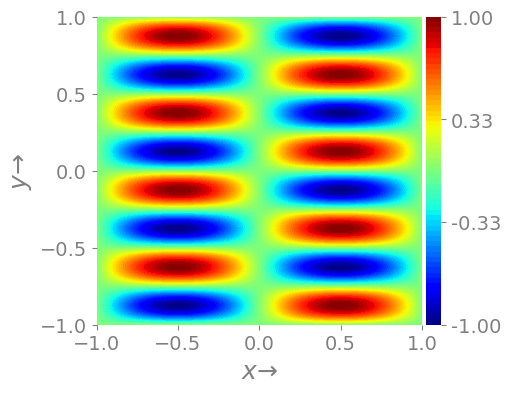

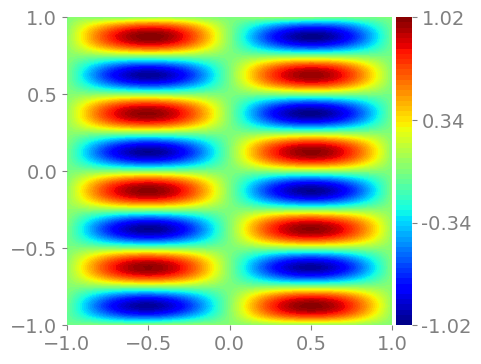

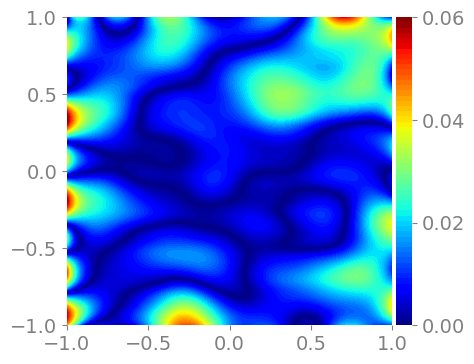

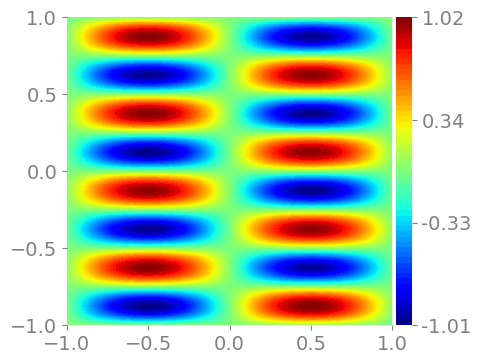

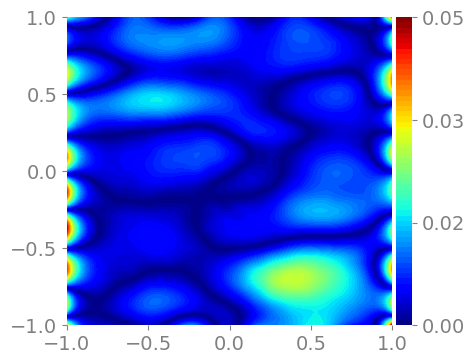

In [38]:
data = [
    u,
    u_pred_tanh,
    np.abs(u_pred_tanh - u),
    u_pred_bspline,
    np.abs(u_pred_bspline - u),
]

titles = [
    "exact_veloctiy_helmholtz",
    "fourier_veloctiy_u_helmholtz",
    "fourier_error_veloctiy_helmholtz",
    "bspline_veloctiy_helmholtz",
    "bspline_error_veloctiy_helmholtz",
]

xy_labels = [r"$x→$", r"$y→$"]

for index, (title, z) in enumerate(zip(titles, data)):
    file_name = os.path.join(model_dirname, f"{title}.png")
    plot_xy = index == 0
    fig = plot_contour(X, z.reshape(100, 100), file_name, plot_xy, xy_labels)